In [25]:
!pip install torchvision timm optuna matplotlib

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os

# Enable benchmark mode in cudnn for faster runtime if input sizes are fixed
torch.backends.cudnn.benchmark = True

# Set device (we will use all available GPUs via DataParallel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Number of GPUs available:", torch.cuda.device_count())


Using device: cuda
Number of GPUs available: 1


In [27]:
from torchvision.transforms import InterpolationMode  # for specifying interpolation modes

# Define transforms for input images: resize, convert to tensor, and normalize.
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet means
                         std=[0.229, 0.224, 0.225])
])

# Define transforms for segmentation masks: resize (with nearest interpolation) then convert to tensor.
target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])

# Define the root directory where VOC will be stored
data_root = './VOCdevkit'

# Load the VOCSegmentation training dataset (using VOC2012)
full_train_dataset = VOCSegmentation(root=data_root,
                                     year='2012',
                                     image_set='train',
                                     download=True,
                                     transform=input_transform,
                                     target_transform=target_transform)

# Split the training dataset into train and validation subsets (80/20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Load the official VOC 'val' split as our test dataset
test_dataset = VOCSegmentation(root=data_root,
                               year='2012',
                               image_set='val',
                               download=True,
                               transform=input_transform,
                               target_transform=target_transform)
print(f"Test samples: {len(test_dataset)}")


Using downloaded and verified file: ./VOCdevkit/VOCtrainval_11-May-2012.tar
Extracting ./VOCdevkit/VOCtrainval_11-May-2012.tar to ./VOCdevkit
Train samples: 1171, Validation samples: 293
Using downloaded and verified file: ./VOCdevkit/VOCtrainval_11-May-2012.tar
Extracting ./VOCdevkit/VOCtrainval_11-May-2012.tar to ./VOCdevkit
Test samples: 1449


In [28]:
batch_size = 8  
num_workers = 8  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,  
                         num_workers=num_workers, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader}


In [29]:
import torch
import torch.nn as nn
import torchvision.models as models

class SegNet(nn.Module):
    def __init__(self, num_classes=21):
        super(SegNet, self).__init__()
        
        # -----------------------
        # Encoder using pretrained VGG16_bn
        # -----------------------
        vgg16_bn = models.vgg16_bn(pretrained=True)
        features = list(vgg16_bn.features.children())
        
        # VGG16_bn architecture is divided into 5 blocks:
        # Block 1: layers 0-5, Block 2: layers 7-12, Block 3: layers 14-22,
        # Block 4: layers 24-32, Block 5: layers 34-42.
        self.encoder_conv1 = nn.Sequential(*features[0:6])   # Block 1
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(*features[7:13])  # Block 2
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_conv3 = nn.Sequential(*features[14:23])  # Block 3
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_conv4 = nn.Sequential(*features[24:33])  # Block 4
        self.pool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_conv5 = nn.Sequential(*features[34:43])  # Block 5
        self.pool5 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        # -----------------------
        # Decoder (mirroring the encoder)
        # -----------------------
        self.unpool5 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.unpool4 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # Reduce channels from 512 to 256 to match the next stage
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.unpool3 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Reduce channels from 256 to 128 to match the next stage
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Reduce channels from 128 to 64 to match encoder stage 1 output
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        x1 = self.encoder_conv1(x)
        x1p, idx1 = self.pool1(x1)
        
        x2 = self.encoder_conv2(x1p)
        x2p, idx2 = self.pool2(x2)
        
        x3 = self.encoder_conv3(x2p)
        x3p, idx3 = self.pool3(x3)
        
        x4 = self.encoder_conv4(x3p)
        x4p, idx4 = self.pool4(x4)
        
        x5 = self.encoder_conv5(x4p)
        x5p, idx5 = self.pool5(x5)
        
        # Decoder
        d5 = self.unpool5(x5p, idx5, output_size=x5.size())
        d5 = self.decoder_conv5(d5)
        
        d4 = self.unpool4(d5, idx4, output_size=x4.size())
        d4 = self.decoder_conv4(d4)
        
        d3 = self.unpool3(d4, idx3, output_size=x3.size())
        d3 = self.decoder_conv3(d3)
        
        d2 = self.unpool2(d3, idx2, output_size=x2.size())
        d2 = self.decoder_conv2(d2)
        
        d1 = self.unpool1(d2, idx1, output_size=x1.size())
        d1 = self.decoder_conv1(d1)
        
        out = self.classifier(d1)
        return out

# Instantiate the VGG-based SegNet and wrap with DataParallel for multi-GPU training
num_classes = 21  # For VOC: 20 classes + background
model = SegNet(num_classes=num_classes)
model = nn.DataParallel(model)  # Use all available GPUs
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(model)


DataParallel(
  (module): SegNet(
    (encoder_conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder_conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    

In [30]:
# def initialize_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

# model.apply(initialize_weights)
# print("Weights initialized with He initialization.")


In [31]:
import torch
import numpy as np

def compute_segmentation_metrics(pred, target, num_classes=21, ignore_index=255):
    """
    Compute segmentation metrics: pixel accuracy, mIoU, F1-score, and Dice coefficient.
    
    Args:
      pred (Tensor): Predicted labels, shape (H, W)
      target (Tensor): Ground truth labels, shape (H, W)
      num_classes (int): Number of classes (default 21 for VOC)
      ignore_index (int): Label to ignore (default 255)
      
    Returns:
      Dictionary of computed metrics.
    """
    # Flatten the prediction and target tensors
    pred = pred.view(-1)
    target = target.view(-1)
    
    # Create a mask to filter out ignore_index pixels
    mask = (target != ignore_index)
    pred = pred[mask]
    target = target[mask]

    # Compute pixel accuracy over valid pixels
    correct = (pred == target).sum().item()
    total = target.numel()  # all remaining pixels
    pixel_acc = correct / total if total > 0 else 0

    # Initialize lists to store per-class metrics
    ious = []
    f1s = []
    dices = []
    epsilon = 1e-6  # Small constant to avoid division by zero
    
    for cls in range(num_classes):
        # Create boolean masks for the current class
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        
        # Use logical operations to compute intersection and union
        intersection = torch.logical_and(pred_inds, target_inds).sum().item()
        union = torch.logical_or(pred_inds, target_inds).sum().item()

        # If the class is absent from both prediction and ground truth, skip it
        if target_inds.sum().item() == 0 and pred_inds.sum().item() == 0:
            continue

        # Compute IoU for the class
        iou = intersection / (union + epsilon)
        ious.append(iou)
        
        # Compute F1 Score (or Dice, which is equivalent in segmentation)
        tp = intersection
        fp = pred_inds.sum().item() - tp
        fn = target_inds.sum().item() - tp
        f1 = 2 * tp / (2 * tp + fp + fn + epsilon)
        f1s.append(f1)
        dices.append(f1)  # F1 and Dice are equivalent here
    
    # Compute the mean over classes that were present
    mean_iou = np.mean(ious) if ious else 0
    mean_f1 = np.mean(f1s) if f1s else 0
    mean_dice = np.mean(dices) if dices else 0

    return {
        'pixel_acc': pixel_acc,
        'mean_iou': mean_iou,
        'f1': mean_f1,
        'dice': mean_dice,
        'ious': ious  # List of per-class IoU values
    }

# Example usage:
# pred_dummy = torch.randint(0, 21, (256, 256))
# target_dummy = torch.randint(0, 21, (256, 256))
# metrics = compute_segmentation_metrics(pred_dummy, target_dummy)
# print(metrics)


Epoch 1/150
------------------------------
Train Loss: 2.1115  Train Acc: 0.5869
Val Loss:   1.6607  Val Acc:   0.6310
Validation loss decreased, saving model...

Epoch 2/150
------------------------------
Train Loss: 1.5488  Train Acc: 0.7070
Val Loss:   1.5085  Val Acc:   0.7483
Validation loss decreased, saving model...

Epoch 3/150
------------------------------
Train Loss: 1.2804  Train Acc: 0.7650
Val Loss:   1.3000  Val Acc:   0.7458
Validation loss decreased, saving model...

Epoch 4/150
------------------------------
Train Loss: 1.1148  Train Acc: 0.7706
Val Loss:   1.1406  Val Acc:   0.7585
Validation loss decreased, saving model...

Epoch 5/150
------------------------------
Train Loss: 0.9797  Train Acc: 0.7792
Val Loss:   1.0830  Val Acc:   0.7435
Validation loss decreased, saving model...

Epoch 6/150
------------------------------
Train Loss: 0.8759  Train Acc: 0.7864
Val Loss:   0.9728  Val Acc:   0.7669
Validation loss decreased, saving model...

Epoch 7/150
----------

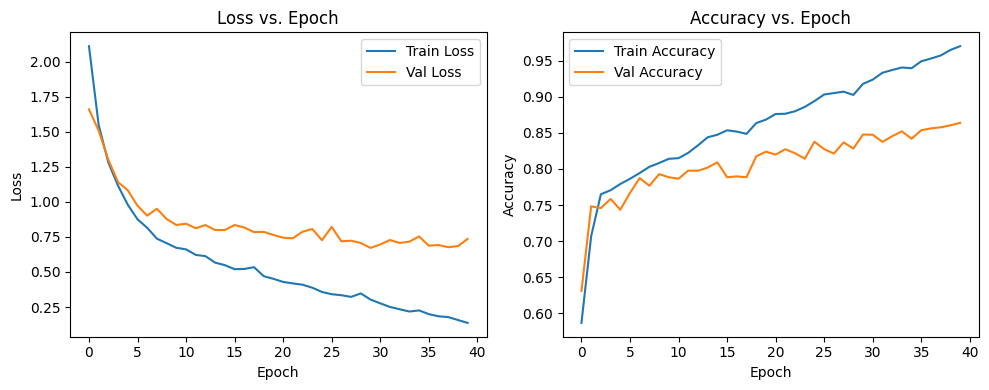

In [32]:
import time, copy
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, num_epochs=150, patience=10):
    """
    Train the segmentation model using the provided criterion (loss function)
    and optimizer. Works with a model wrapped in DataParallel for multi-GPU training.
    
    Args:
      model: The segmentation model (wrapped with DataParallel).
      dataloaders: A dictionary with keys 'train' and 'val' containing DataLoaders.
      criterion: The loss function (e.g., nn.CrossEntropyLoss with ignore_index set).
      optimizer: The optimizer (e.g., Adam) for updating model weights.
      num_epochs: Maximum number of epochs for training.
      patience: Number of epochs with no improvement on validation loss before early stopping.
    
    Returns:
      model: The best-performing model on the validation set.
      train_losses: List of training losses per epoch.
      val_losses: List of validation losses per epoch.
      train_accuracies: List of training accuracies per epoch.
      val_accuracies: List of validation accuracies per epoch.
    """
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        epoch_train_correct = 0
        epoch_val_correct = 0
        train_total_pixels = 0
        val_total_pixels = 0
        
        # Training phase
        model.train()
        for inputs, targets in dataloaders["train"]:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)  # (B, num_classes, H, W)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)
            
            # Compute pixel accuracy ignoring ignore_index pixels.
            valid_mask = (targets != 255)
            epoch_train_correct += ((preds == targets) * valid_mask).sum().item()
            train_total_pixels += valid_mask.sum().item()
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * inputs.size(0)
        
        train_loss = epoch_train_loss / len(dataloaders["train"].dataset)
        train_acc = epoch_train_correct / train_total_pixels if train_total_pixels > 0 else 0
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, targets in dataloaders["val"]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                preds = torch.argmax(outputs, dim=1)
                
                valid_mask = (targets != 255)
                epoch_val_correct += ((preds == targets) * valid_mask).sum().item()
                val_total_pixels += valid_mask.sum().item()
                
                epoch_val_loss += loss.item() * inputs.size(0)
        val_loss = epoch_val_loss / len(dataloaders["val"].dataset)
        val_acc = epoch_val_correct / val_total_pixels if val_total_pixels > 0 else 0
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f}  Val Acc:   {val_acc:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print("Validation loss decreased, saving model...")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Loss: {best_loss:.4f}")
    
    model.load_state_dict(best_model_wts)
    
    # Plot training vs. validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    
    # Plot training vs. validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Define loss criterion and optimizer using simple CrossEntropyLoss
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model with increased epochs (150) and patience (10)
model, train_losses, val_losses, train_accs, val_accs = train_model(model, dataloaders, criterion, optimizer,
                                                                     num_epochs=150, patience=10)


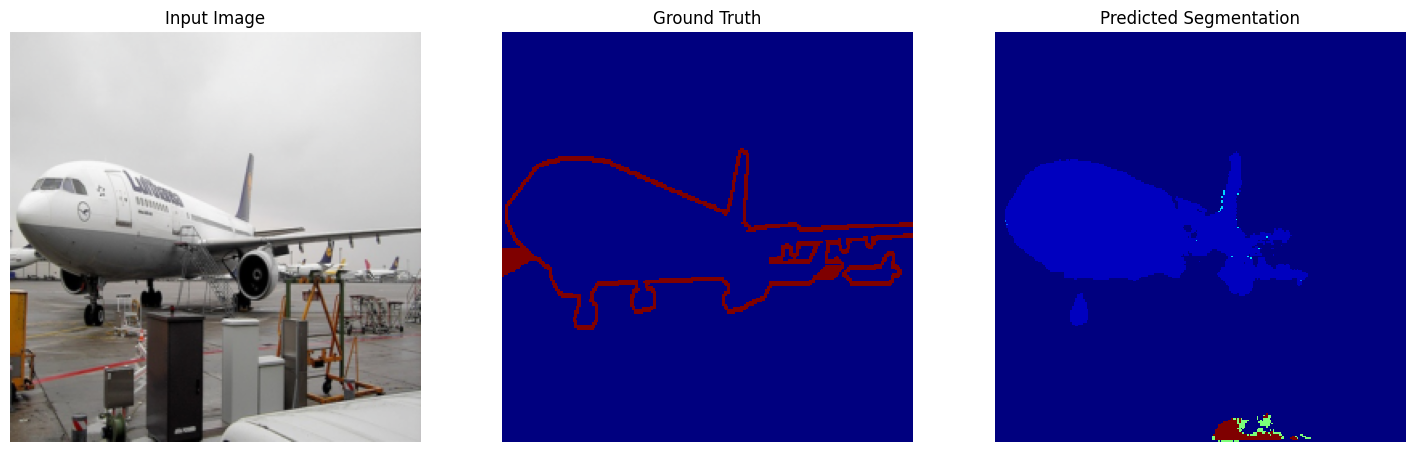

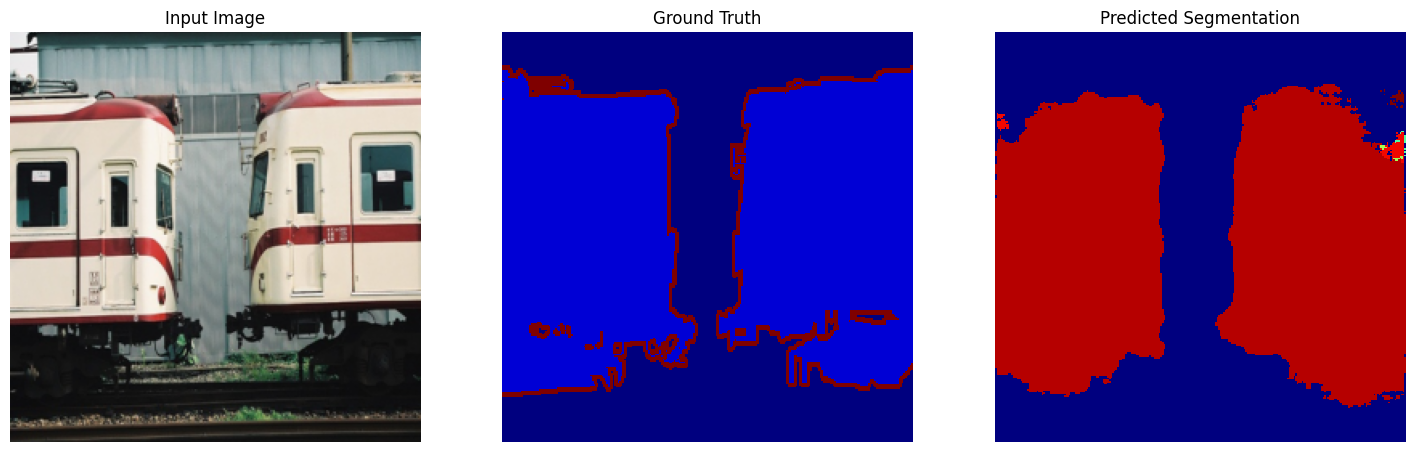

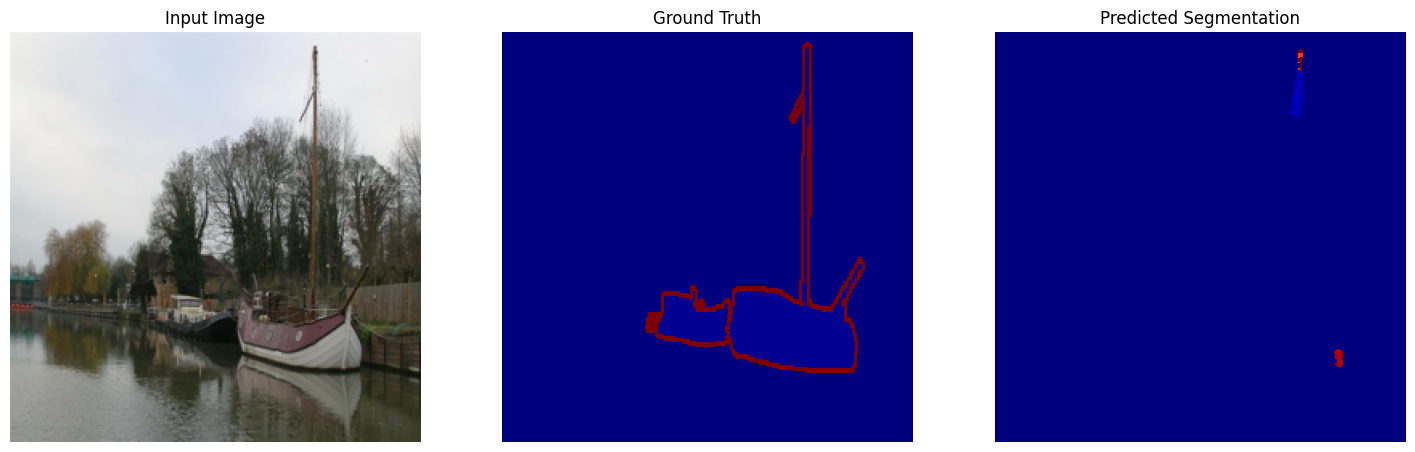

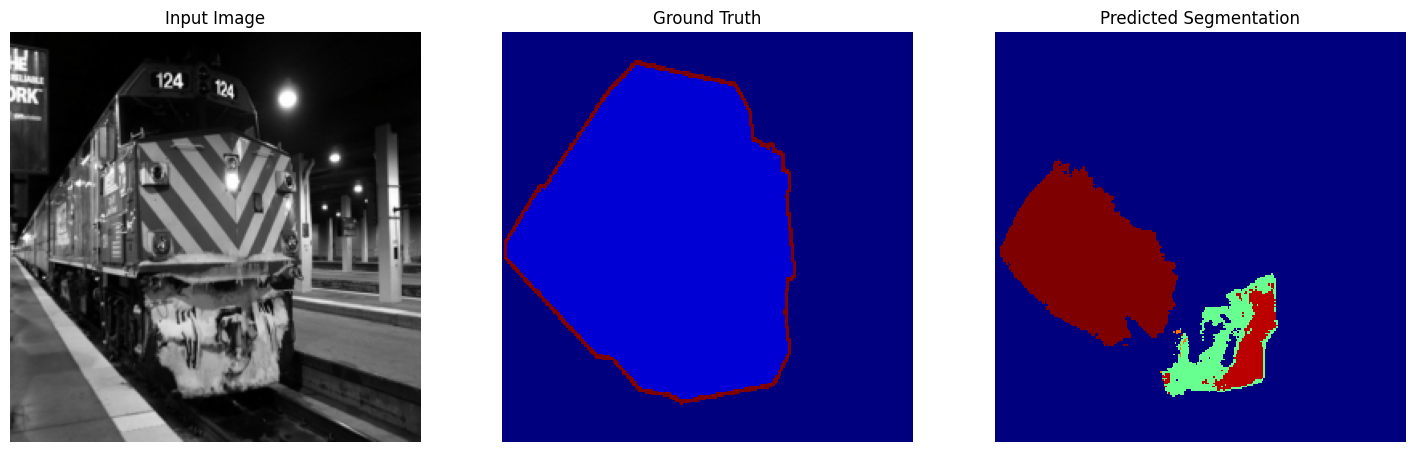

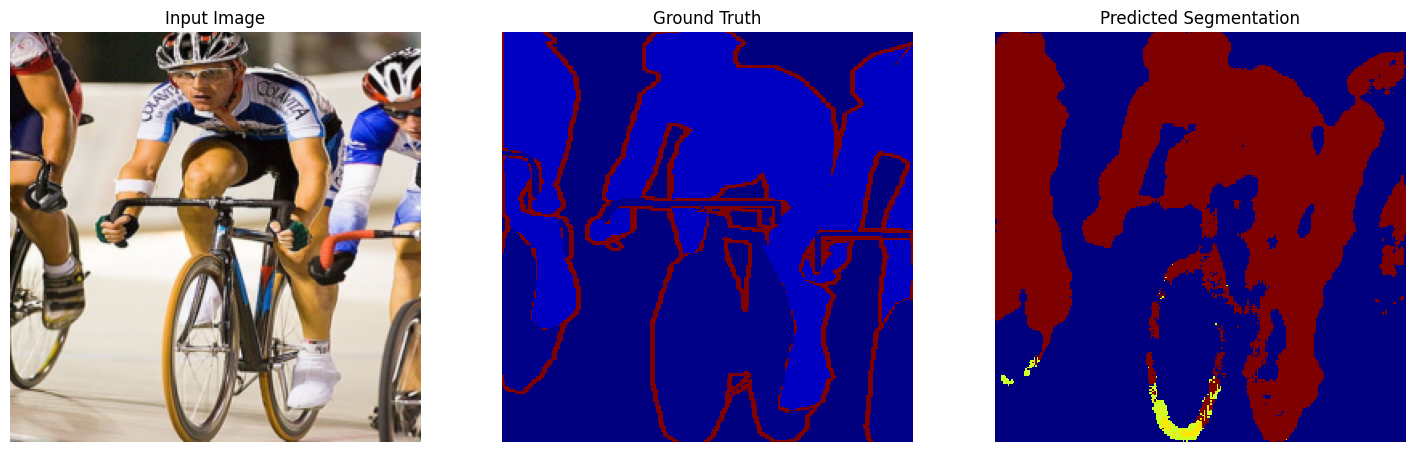

Test Metrics:
Pixel Accuracy: 0.8444
Mean IoU: 0.3030
F1 Score: 0.3278
Dice Score: 0.3278


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode (this works with a DataParallel-wrapped model)
model.eval()

# Containers for aggregated metrics
total_pixel_acc = 0
total_mean_iou = 0
total_f1 = 0
total_dice = 0
num_samples = 0

# Number of samples to display
num_display = 5
displayed = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        # Move data to device (DataParallel will distribute across GPUs)
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)
        
        # Process each sample in the batch separately
        for b in range(inputs.size(0)):
            metrics = compute_segmentation_metrics(preds[b].cpu(), targets[b].cpu(), num_classes=num_classes)
            total_pixel_acc += metrics['pixel_acc']
            total_mean_iou += metrics['mean_iou']
            total_f1 += metrics['f1']
            total_dice += metrics['dice']
            num_samples += 1
            
            # Display the image if we haven't reached our limit
            if displayed < num_display:
                input_img = inputs[b].cpu().permute(1, 2, 0).numpy()
                # Undo normalization for display (assuming ImageNet normalization)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_img = std * input_img + mean
                input_img = np.clip(input_img, 0, 1)
                
                # Plotting
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1)
                plt.imshow(input_img)
                plt.title('Input Image')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(targets[b].cpu(), cmap='jet', interpolation='nearest')
                plt.title('Ground Truth')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(preds[b].cpu(), cmap='jet', interpolation='nearest')
                plt.title('Predicted Segmentation')
                plt.axis('off')
                plt.show()
                
                displayed += 1

# Compute average metrics over all samples
avg_pixel_acc = total_pixel_acc / num_samples
avg_mean_iou = total_mean_iou / num_samples
avg_f1 = total_f1 / num_samples
avg_dice = total_dice / num_samples

print("Test Metrics:")
print(f"Pixel Accuracy: {avg_pixel_acc:.4f}")
print(f"Mean IoU: {avg_mean_iou:.4f}")
print(f"F1 Score: {avg_f1:.4f}")
print(f"Dice Score: {avg_dice:.4f}")


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class EfficientSegNet(nn.Module):
    def __init__(self, num_classes=21):
        super(EfficientSegNet, self).__init__()
        # Load EfficientNet-B0 backbone (features_only returns intermediate features)
        self.encoder = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)
        # Example feature info for EfficientNet-B0:
        # Stage 0: resolution ~ H/2, channels = 24
        # Stage 1: resolution ~ H/4, channels = 40
        # Stage 2: resolution ~ H/8, channels = 80
        # Stage 3: resolution ~ H/16, channels = 112
        # Stage 4: resolution ~ H/32, channels = 1280

        # We'll use the last three stages for decoding.
        # Decoder Stage 1: from stage 4 (bottleneck) to stage 3 resolution
        self.decoder4 = nn.Sequential(
            nn.Conv2d(self.encoder.feature_info[-1]['num_chs'], 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Decoder Stage 2: from stage 3 to stage 2 resolution
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Decoder Stage 3: from stage 2 to stage 1 resolution
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Decoder Stage 4: from stage 1 to half resolution (currently at H/2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # NEW: Decoder Stage 0: upsample from H/2 to full resolution (256×256)
        self.decoder0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.up0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Final classifier: now input channels = 32, output channels = num_classes.
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Extract multi-scale features from the EfficientNet encoder.
        features = self.encoder(x)
        # Use the last three stages (or adjust as needed)
        x = self.decoder4(features[-1])  # from stage 4 (bottleneck)
        x = self.up4(x)                   # upsample to roughly stage -2 resolution
        
        x = self.decoder3(x)
        x = self.up3(x)                   # upsample further
        
        x = self.decoder2(x)
        x = self.up2(x)                   # upsample further
        
        x = self.decoder1(x)
        x = self.up1(x)                   # now resolution is half of original (e.g., 128×128 if input is 256×256)
        
        x = self.decoder0(x)
        x = self.up0(x)                   # upsample to original resolution (256×256)
        
        out = self.classifier(x)
        return out

# Setup device and instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficient_segnet = EfficientSegNet(num_classes=21)

# Wrap the model with DataParallel for multi-GPU training
efficient_segnet = nn.DataParallel(efficient_segnet)
efficient_segnet = efficient_segnet.to(device)

print(efficient_segnet)


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


DataParallel(
  (module): EfficientSegNet(
    (encoder): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), 

Epoch 1/150
------------------------------
Train Loss: 2.2182  Train Acc: 0.6250
Val   Loss: 1.8564  Val   Acc: 0.7454
Validation loss decreased, saving model...

Epoch 2/150
------------------------------
Train Loss: 1.8208  Train Acc: 0.7361
Val   Loss: 1.7010  Val   Acc: 0.7787
Validation loss decreased, saving model...

Epoch 3/150
------------------------------
Train Loss: 1.5607  Train Acc: 0.7774
Val   Loss: 1.4122  Val   Acc: 0.8014
Validation loss decreased, saving model...

Epoch 4/150
------------------------------
Train Loss: 1.3521  Train Acc: 0.8011
Val   Loss: 1.2243  Val   Acc: 0.8090
Validation loss decreased, saving model...

Epoch 5/150
------------------------------
Train Loss: 1.1602  Train Acc: 0.8315
Val   Loss: 1.0617  Val   Acc: 0.8485
Validation loss decreased, saving model...

Epoch 6/150
------------------------------
Train Loss: 1.0000  Train Acc: 0.8556
Val   Loss: 0.9639  Val   Acc: 0.8484
Validation loss decreased, saving model...

Epoch 7/150
----------

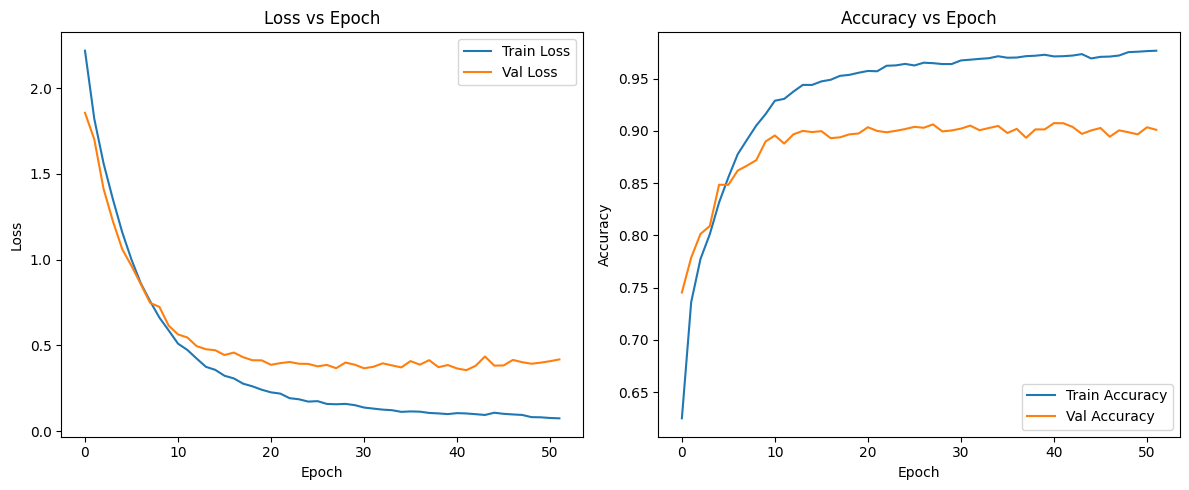

In [35]:
import time, copy
import matplotlib.pyplot as plt

def train_model(model, dataloaders, optimizer, num_epochs=150, patience=10):
    """
    Train the segmentation model using simple CrossEntropyLoss (with ignore_index).
    Expects dataloaders to have 'train' and 'val' splits.
    Works with models wrapped in DataParallel for multi-GPU training.
    
    Returns:
      model: The best-performing model on the validation set.
      train_losses: List of training losses per epoch.
      val_losses: List of validation losses per epoch.
      train_accs: List of training accuracies per epoch.
      val_accs: List of validation accuracies per epoch.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        epoch_train_correct = 0
        epoch_val_correct = 0
        train_total_pixels = 0
        val_total_pixels = 0

        # Training phase
        model.train()
        for inputs, targets in dataloaders["train"]:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # (B, num_classes, H, W)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            # Compute pixel accuracy ignoring ignore_index pixels
            valid_mask = (targets != 255)
            epoch_train_correct += ((preds == targets) * valid_mask).sum().item()
            train_total_pixels += valid_mask.sum().item()

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * inputs.size(0)

        train_loss = epoch_train_loss / len(dataloaders["train"].dataset)
        train_acc = epoch_train_correct / train_total_pixels if train_total_pixels > 0 else 0
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, targets in dataloaders["val"]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                preds = torch.argmax(outputs, dim=1)

                valid_mask = (targets != 255)
                epoch_val_correct += ((preds == targets) * valid_mask).sum().item()
                val_total_pixels += valid_mask.sum().item()

                epoch_val_loss += loss.item() * inputs.size(0)
        val_loss = epoch_val_loss / len(dataloaders["val"].dataset)
        val_acc = epoch_val_correct / val_total_pixels if val_total_pixels > 0 else 0
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.4f}")

        # Check for improvement on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print("Validation loss decreased, saving model...")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model, train_losses, val_losses, train_accs, val_accs

# Define the loss criterion and optimizer using simple CrossEntropyLoss
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(efficient_segnet.parameters(), lr=1e-4)

# Train the model with increased epochs (150) and patience (10)
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(efficient_segnet, dataloaders, optimizer,
                                                                              num_epochs=150, patience=10)


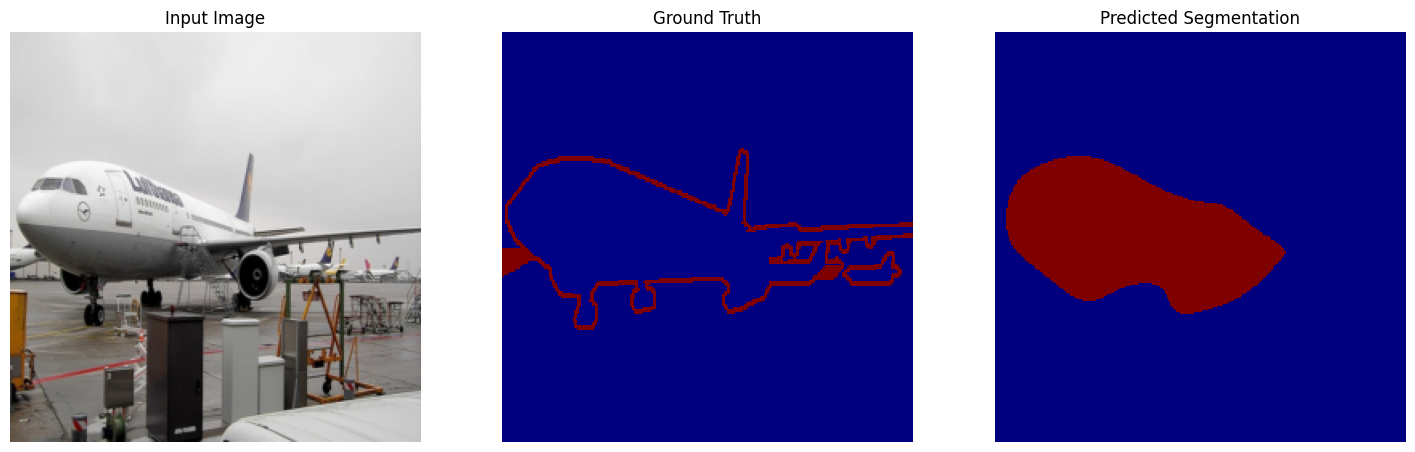

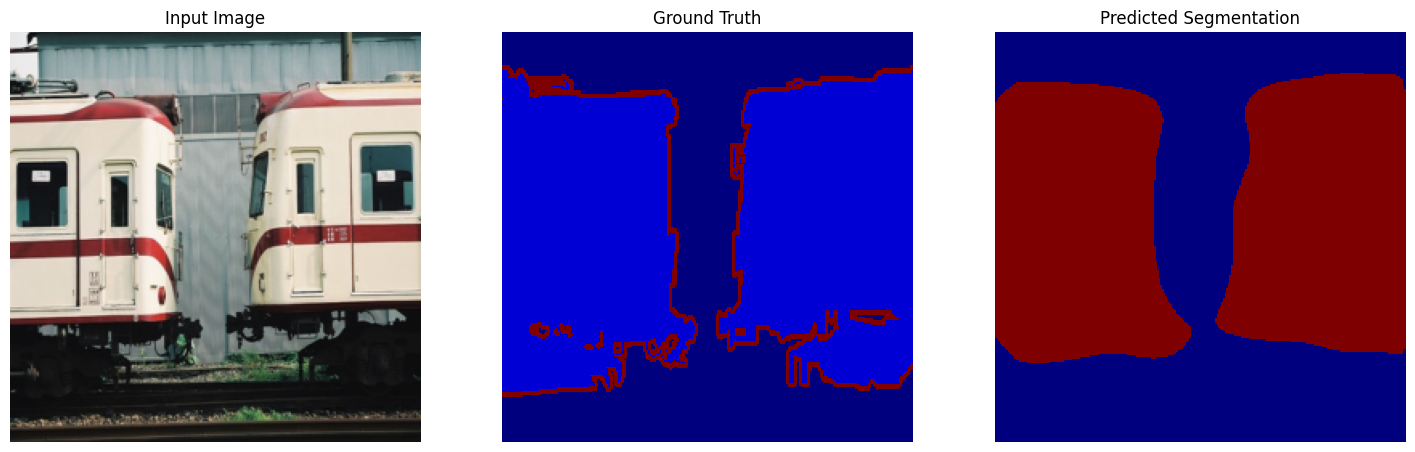

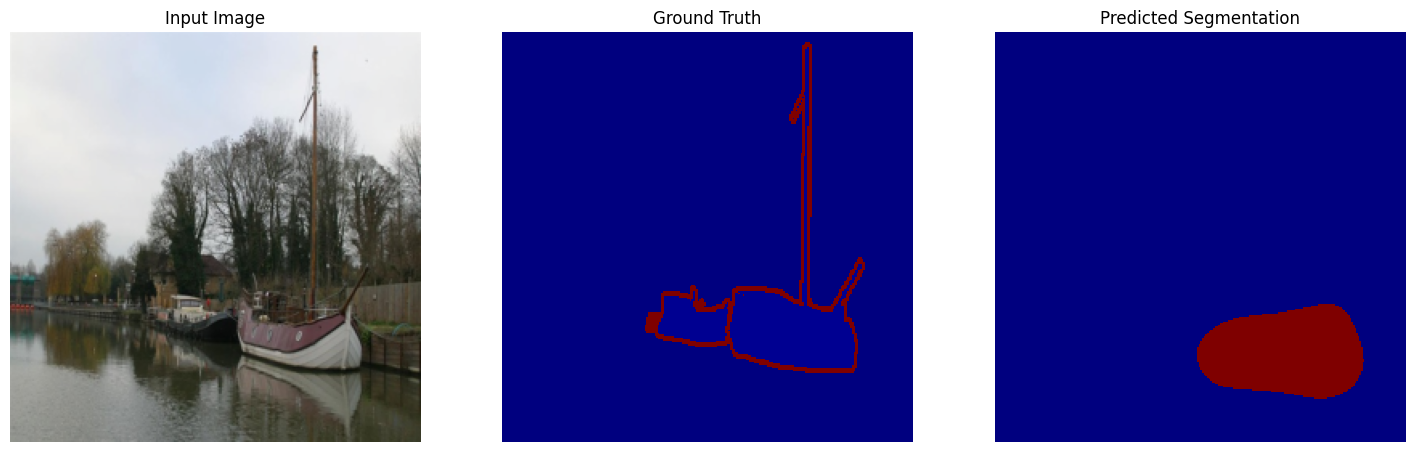

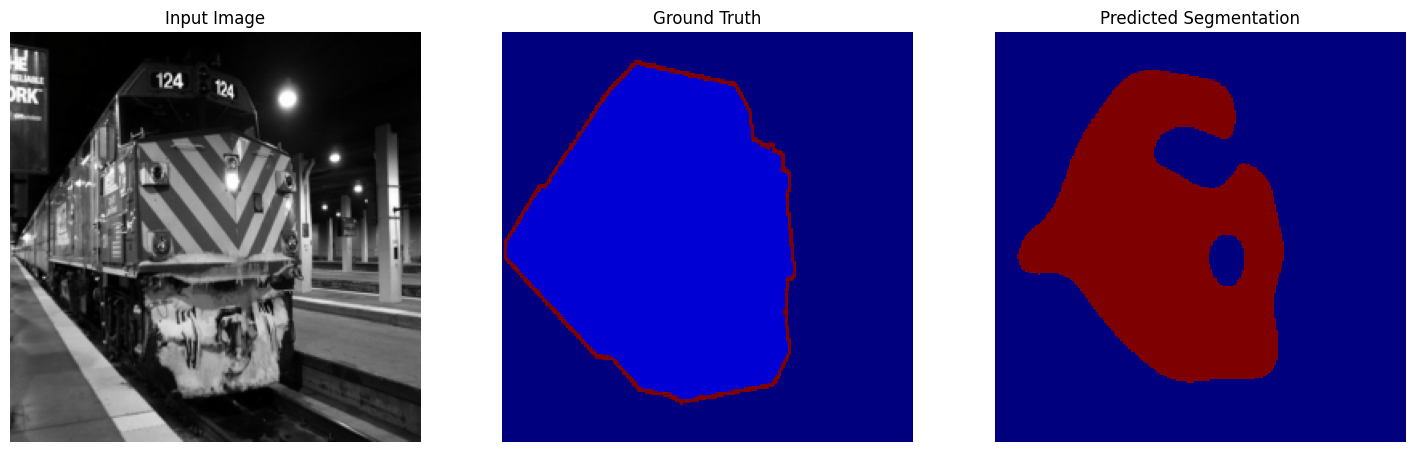

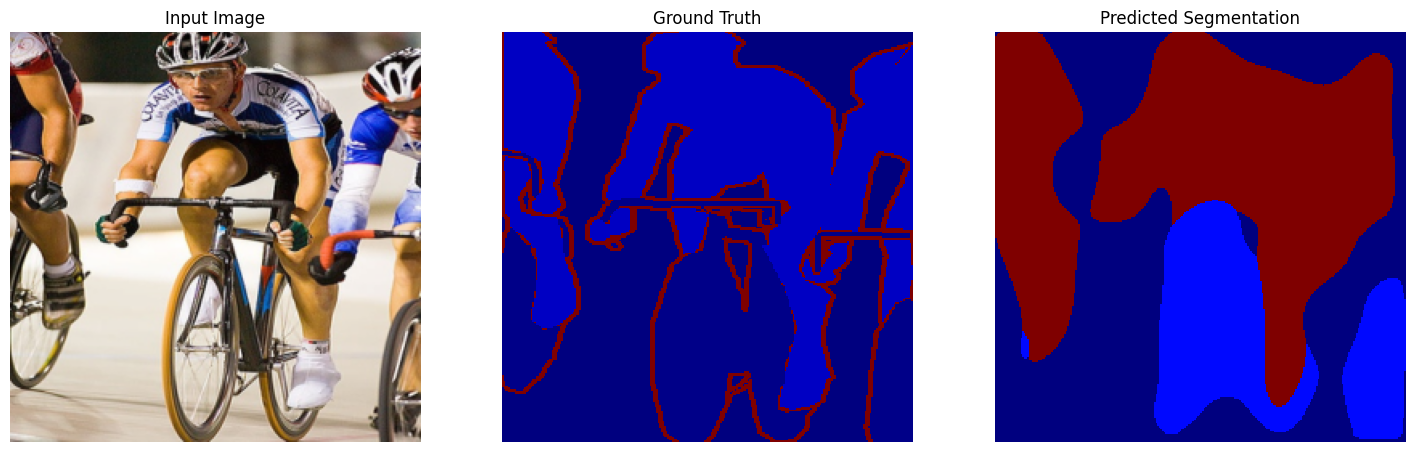

Test Metrics:
Pixel Accuracy: 0.8980
Mean IoU: 0.6067
F1 Score: 0.6607
Dice Score: 0.6607


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode (works for both VGG-based and EfficientNet-based models wrapped in DataParallel)
model.eval()

# Containers for aggregated metrics
total_pixel_acc = 0
total_mean_iou = 0
total_f1 = 0
total_dice = 0
num_samples = 0

# Number of samples to display
num_display = 5
displayed = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        # Move inputs and targets to the proper device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = trained_model(inputs)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)
        
        # Process each sample in the batch separately
        for b in range(inputs.size(0)):
            # Compute metrics using the helper function (which expects CPU tensors)
            metrics = compute_segmentation_metrics(preds[b].cpu(), targets[b].cpu(), num_classes=num_classes)
            total_pixel_acc += metrics['pixel_acc']
            total_mean_iou += metrics['mean_iou']
            total_f1 += metrics['f1']
            total_dice += metrics['dice']
            num_samples += 1
            
            # Display the image if we haven't reached our display limit
            if displayed < num_display:
                input_img = inputs[b].cpu().permute(1, 2, 0).numpy()
                # Undo normalization for display (assuming ImageNet normalization)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_img = std * input_img + mean
                input_img = np.clip(input_img, 0, 1)
                
                # Plotting the input, ground truth, and predicted segmentation
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1)
                plt.imshow(input_img)
                plt.title('Input Image')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(targets[b].cpu(), cmap='jet', interpolation='nearest')
                plt.title('Ground Truth')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(preds[b].cpu(), cmap='jet', interpolation='nearest')
                plt.title('Predicted Segmentation')
                plt.axis('off')
                plt.show()
                
                displayed += 1

# Compute average metrics over all samples
avg_pixel_acc = total_pixel_acc / num_samples
avg_mean_iou = total_mean_iou / num_samples
avg_f1 = total_f1 / num_samples
avg_dice = total_dice / num_samples

print("Test Metrics:")
print(f"Pixel Accuracy: {avg_pixel_acc:.4f}")
print(f"Mean IoU: {avg_mean_iou:.4f}")
print(f"F1 Score: {avg_f1:.4f}")
print(f"Dice Score: {avg_dice:.4f}")


In [37]:
import time
import torch

def evaluate_inference_speed(model, dataloader, device):
    """
    Measures average inference time per sample.
    
    Args:
      model: A segmentation model (wrapped in DataParallel).
      dataloader: DataLoader for the evaluation dataset.
      device: Device to run the model on.
      
    Returns:
      Average inference time per sample in seconds.
    """
    model.eval()
    total_time = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            start = time.time()
            _ = model(inputs)
            end = time.time()
            batch_time = end - start
            total_time += batch_time
            total_samples += inputs.size(0)
    avg_time_per_sample = total_time / total_samples
    return avg_time_per_sample

# Example usage:
avg_time_vgg = evaluate_inference_speed(model, test_loader, device)
avg_time_effnet = evaluate_inference_speed(efficient_segnet, test_loader, device)

print("Average inference time per sample:")
print("VGG-based SegNet: {:.4f} sec".format(avg_time_vgg))
print("EfficientNet-based SegNet: {:.4f} sec".format(avg_time_effnet))


Average inference time per sample:
VGG-based SegNet: 0.0030 sec
EfficientNet-based SegNet: 0.0061 sec


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

def grid_search_tuning(model_class, model_name, lr_values, alpha_values, dataloaders, device, num_epochs=5):
    """
    Performs a grid search over lr and alpha for a given model class.
    
    Args:
      model_class: The model class to instantiate (e.g., SegNet or EfficientSegNet)
      model_name: String name for logging purposes.
      lr_values: List of learning rates to try.
      alpha_values: List of alpha values (loss weight) to try.
      dataloaders: Dictionary containing 'train' and 'val' DataLoaders.
      device: torch.device to use.
      num_epochs: Number of epochs to train for each combination.
      
    Returns:
      A list of dictionaries with the hyperparameters and best validation loss for each combination.
    """
    results = []
    for lr in lr_values:
        for alpha in alpha_values:
            print(f"Training {model_name} with lr={lr}, alpha={alpha}")
            # Instantiate a new model and wrap with DataParallel for multi-GPU training.
            model = model_class(num_classes=21).to(device)
            model = nn.DataParallel(model)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            # Define loss functions
            criterion_ce = nn.CrossEntropyLoss(ignore_index=255)
            criterion_dice = DiceLoss(smooth=1.0, ignore_index=255)
            
            # Define combined loss function with current alpha
            def combined_loss(outputs, targets):
                return alpha * criterion_ce(outputs, targets) + (1 - alpha) * criterion_dice(outputs, targets)
            
            best_val_loss = float('inf')
            
            # Train for a limited number of epochs
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for inputs, targets in dataloaders["train"]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = combined_loss(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                train_loss = running_loss / len(dataloaders["train"].dataset)
                
                # Evaluate on validation set
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in dataloaders["val"]:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        outputs = model(inputs)
                        loss = combined_loss(outputs, targets)
                        val_loss += loss.item() * inputs.size(0)
                val_loss /= len(dataloaders["val"].dataset)
                print(f"  Epoch {epoch+1}/{num_epochs}: Val Loss = {val_loss:.4f}")
                best_val_loss = min(best_val_loss, val_loss)
            
            results.append({
                'model': model_name,
                'lr': lr,
                'alpha': alpha,
                'best_val_loss': best_val_loss
            })
            print(f"Completed {model_name} with lr={lr}, alpha={alpha}, Best Val Loss: {best_val_loss:.4f}\n")
    return results

# Define hyperparameter grids
lr_values = [1e-5, 1e-4, 1e-3]
alpha_values = [0.3, 0.5, 0.7]
num_grid_epochs = 5  # Adjust the number of epochs for grid search if desired

# Grid search for VGG-based SegNet
results_vgg = grid_search_tuning(SegNet, "VGG-based SegNet", lr_values, alpha_values, dataloaders, device, num_epochs=num_grid_epochs)

# Grid search for EfficientNet-based SegNet
results_effnet = grid_search_tuning(EfficientSegNet, "EfficientNet-based SegNet", lr_values, alpha_values, dataloaders, device, num_epochs=num_grid_epochs)

# Print the results for each model
print("Results for VGG-based SegNet:")
for r in results_vgg:
    print(r)

print("\nResults for EfficientNet-based SegNet:")
for r in results_effnet:
    print(r)


Training VGG-based SegNet with lr=1e-05, alpha=0.3
  Epoch 1/5: Val Loss = 1.5052
  Epoch 2/5: Val Loss = 1.4129
  Epoch 3/5: Val Loss = 1.3757
  Epoch 4/5: Val Loss = 1.3077
  Epoch 5/5: Val Loss = 1.3094
Completed VGG-based SegNet with lr=1e-05, alpha=0.3, Best Val Loss: 1.3077

Training VGG-based SegNet with lr=1e-05, alpha=0.5
  Epoch 1/5: Val Loss = 1.7883
  Epoch 2/5: Val Loss = 1.6506
  Epoch 3/5: Val Loss = 1.5716
  Epoch 4/5: Val Loss = 1.4937
  Epoch 5/5: Val Loss = 1.5011
Completed VGG-based SegNet with lr=1e-05, alpha=0.5, Best Val Loss: 1.4937

Training VGG-based SegNet with lr=1e-05, alpha=0.7
  Epoch 1/5: Val Loss = 2.0400
  Epoch 2/5: Val Loss = 1.9841
  Epoch 3/5: Val Loss = 1.7414
  Epoch 4/5: Val Loss = 1.7640
  Epoch 5/5: Val Loss = 1.5214
Completed VGG-based SegNet with lr=1e-05, alpha=0.7, Best Val Loss: 1.5214

Training VGG-based SegNet with lr=0.0001, alpha=0.3
  Epoch 1/5: Val Loss = 1.2366
  Epoch 2/5: Val Loss = 1.1171
  Epoch 3/5: Val Loss = 1.0633
  Epoch 4

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.2062
Completed VGG-based SegNet with lr=0.001, alpha=0.7, Best Val Loss: 1.1800

Training EfficientNet-based SegNet with lr=1e-05, alpha=0.3
  Epoch 1/5: Val Loss = 1.4356
  Epoch 2/5: Val Loss = 1.3725
  Epoch 3/5: Val Loss = 1.3322
  Epoch 4/5: Val Loss = 1.3170


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.2980
Completed EfficientNet-based SegNet with lr=1e-05, alpha=0.3, Best Val Loss: 1.2980

Training EfficientNet-based SegNet with lr=1e-05, alpha=0.5
  Epoch 1/5: Val Loss = 1.8212
  Epoch 2/5: Val Loss = 1.7178
  Epoch 3/5: Val Loss = 1.6685
  Epoch 4/5: Val Loss = 1.6253


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.5884
Completed EfficientNet-based SegNet with lr=1e-05, alpha=0.5, Best Val Loss: 1.5884

Training EfficientNet-based SegNet with lr=1e-05, alpha=0.7
  Epoch 1/5: Val Loss = 2.0796
  Epoch 2/5: Val Loss = 1.9699
  Epoch 3/5: Val Loss = 1.8644
  Epoch 4/5: Val Loss = 1.8342


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.7662
Completed EfficientNet-based SegNet with lr=1e-05, alpha=0.7, Best Val Loss: 1.7662

Training EfficientNet-based SegNet with lr=0.0001, alpha=0.3
  Epoch 1/5: Val Loss = 1.2483
  Epoch 2/5: Val Loss = 1.1877
  Epoch 3/5: Val Loss = 1.1014
  Epoch 4/5: Val Loss = 1.0150


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 0.9675
Completed EfficientNet-based SegNet with lr=0.0001, alpha=0.3, Best Val Loss: 0.9675

Training EfficientNet-based SegNet with lr=0.0001, alpha=0.5
  Epoch 1/5: Val Loss = 1.4899
  Epoch 2/5: Val Loss = 1.3109
  Epoch 3/5: Val Loss = 1.2181
  Epoch 4/5: Val Loss = 1.1068


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.0313
Completed EfficientNet-based SegNet with lr=0.0001, alpha=0.5, Best Val Loss: 1.0313

Training EfficientNet-based SegNet with lr=0.0001, alpha=0.7
  Epoch 1/5: Val Loss = 1.8214
  Epoch 2/5: Val Loss = 1.6849
  Epoch 3/5: Val Loss = 1.5164
  Epoch 4/5: Val Loss = 1.2208


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 1.1405
Completed EfficientNet-based SegNet with lr=0.0001, alpha=0.7, Best Val Loss: 1.1405

Training EfficientNet-based SegNet with lr=0.001, alpha=0.3
  Epoch 1/5: Val Loss = 0.9733
  Epoch 2/5: Val Loss = 0.9157
  Epoch 3/5: Val Loss = 0.9010
  Epoch 4/5: Val Loss = 0.9008


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 0.9206
Completed EfficientNet-based SegNet with lr=0.001, alpha=0.3, Best Val Loss: 0.9008

Training EfficientNet-based SegNet with lr=0.001, alpha=0.5
  Epoch 1/5: Val Loss = 0.9744
  Epoch 2/5: Val Loss = 0.8834
  Epoch 3/5: Val Loss = 0.8570
  Epoch 4/5: Val Loss = 0.8718


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Epoch 5/5: Val Loss = 0.8710
Completed EfficientNet-based SegNet with lr=0.001, alpha=0.5, Best Val Loss: 0.8570

Training EfficientNet-based SegNet with lr=0.001, alpha=0.7
  Epoch 1/5: Val Loss = 1.0473
  Epoch 2/5: Val Loss = 0.8659
  Epoch 3/5: Val Loss = 0.8510
  Epoch 4/5: Val Loss = 0.8062
  Epoch 5/5: Val Loss = 0.7880
Completed EfficientNet-based SegNet with lr=0.001, alpha=0.7, Best Val Loss: 0.7880

Results for VGG-based SegNet:
{'model': 'VGG-based SegNet', 'lr': 1e-05, 'alpha': 0.3, 'best_val_loss': 1.3076769426821035}
{'model': 'VGG-based SegNet', 'lr': 1e-05, 'alpha': 0.5, 'best_val_loss': 1.493671879426611}
{'model': 'VGG-based SegNet', 'lr': 1e-05, 'alpha': 0.7, 'best_val_loss': 1.5214437343968465}
{'model': 'VGG-based SegNet', 'lr': 0.0001, 'alpha': 0.3, 'best_val_loss': 0.9592669201385446}
{'model': 'VGG-based SegNet', 'lr': 0.0001, 'alpha': 0.5, 'best_val_loss': 0.9997790071337703}
{'model': 'VGG-based SegNet', 'lr': 0.0001, 'alpha': 0.7, 'best_val_loss': 0.979417